Links:
* [How to Use Word Embedding Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
* [What Are Word Embeddings for Text?](https://machinelearningmastery.com/what-are-word-embeddings/)
* [How to Develop a Word Embedding Model for Predicting Movie Review Sentiment
](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/)
* [Embed, encode, attend, predict: The new deep learning formula for state-of-the-art NLP models](https://explosion.ai/blog/deep-learning-formula-nlp)
* [How to Develop Word Embeddings in Python with Gensim](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import models

import pandas as pd
import numpy as np
import os
import encoders
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# Dataset
categories = ['Democrat', 'Republican']
tweetsdf = pd.read_csv('democratvsrepublicantweets/ExtractedTweets.csv')
handlesdf = pd.read_csv('democratvsrepublicantweets/TwitterHandles.csv')
raw_tweets = tweetsdf['Tweet']
normalized_tweets = raw_tweets.str.upper()
char_to_int, int_to_char = encoders.create_encoder_decoder(normalized_tweets.str.cat())
parties = tweetsdf['Party']
y = 1.0 - np.asarray(parties == 'Democrat')
max_tweet_len = normalized_tweets.str.len().max()
X = encoders.encode_strings(normalized_tweets, char_to_int, max_tweet_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
filepath, model = models.model3(len(char_to_int), max_tweet_len)
if filepath in os.listdir():
    model.load_weights(filepath)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 166, 256)          134400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 163, 256)          262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 163, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)  

In [4]:
# models.train(X_train, y_train, model, filepath)

In [5]:
predictions = np.argmax(model.predict(X_test), axis=1)

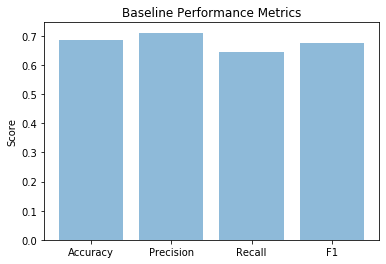

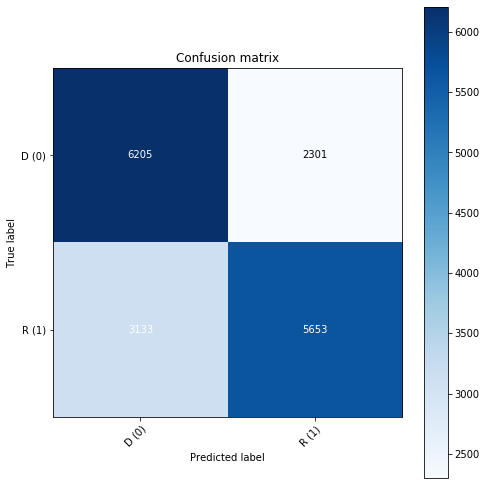

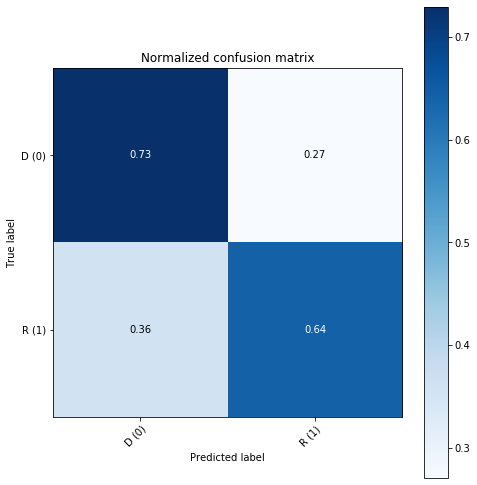

Accuracy: 0.6857506361323156
Precision: 0.710711591651999
Recall: 0.6434099704074664
F1: 0.6753882915173238


In [6]:
metrics, confusion_matrix = models.plot_results(y_test, predictions)
(accuracy, precision, recall, f1) = metrics
print('Accuracy: %s' % accuracy)
print('Precision: %s' % precision)
print('Recall: %s' % recall)
print('F1: %s' % f1)

In [7]:
metrics

[0.6857506361323156, 0.710711591651999, 0.6434099704074664, 0.6753882915173238]